In [1]:
from IPython.display import Image
import xlsxwriter
import openpyxl
import pandas as pd
from matplotlib import rc
rc('font', family='Malgun Gothic')
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import xlsxwriter
import openpyxl
import pandas as pd
from matplotlib import rc
rc('font', family='Malgun Gothic')
%matplotlib inline
%config InlineBacked.figure_format = {'png', 'retina'}
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)



In [2]:
donour = pd.read_excel("./datas/Donour.xlsx",'②후원내역')
rating_18_1 = pd.read_excel("./datas/Rating_18-1.xlsx",'③송출내역-18년-1')
rating_18_2 = pd.read_excel("./datas/Rating_18-2.xlsx",'③송출내역-18년-2')
rating_19 = pd.read_excel("./datas/Rating_19.xlsx",'③송출내역-19년')
rating_20 = pd.read_excel("./datas/Rating_20.xlsx",'③송출내역-20년')
donour.head(4)

,Date,Time,Daypart,Dnis,Station,I/B콜수,응대호,정기후원,후원금액,Film,연월
0,2018-01-01,09:30:00,09시대,1899-0219,Ch.view,0,0,1,20000,진우,1801월
1,2018-01-02,08:45:00,08시대,1899-0263,MBC드라마,1,1,0,0,"최선규,죽기위해태어나는아이가있을까요",1801월
2,2018-01-02,09:00:00,09시대,1899-0263,MBC드라마,0,0,1,20000,"최선규,죽기위해태어나는아이가있을까요",1801월
3,2018-01-02,09:45:00,09시대,1899-7319,SkyTravel,1,1,2,50000,",이아이의눈에서눈물을멈추게할수는없을까",1801월


In [3]:
rating = pd.concat([rating_18_1, rating_18_2, rating_19, rating_20], axis = 0).reset_index()
rating.head(1)

,index,Station,Date,Time,Secs,Film,Programme,Genre,Net Price,Cost,Audience,Salehouse,promocode,pib,pip,origin,telno,SPOT,Daypart,연월
0,0,GTV,2018-06-10,07:45:26,60,Kayembe-KRW20k,속풀이쇼동치미,Ent:Talk show,30354.131535,33389.544688,0.0,NaN,NaN,Pre,end,NaN,NaN,1,07시대,1806월


In [4]:
# 큐시트 : 광고방송스케쥴
cue_sheet = pd.read_excel("./datas/Cuesheet.xlsx",'①큐시트')
cue_sheet.head(1)

,Station,Programme,Time,Daypart,Class,Secs,Kinds,Unit price,Bonus rate,Net price,Insertion,Ad value,Cost,Date,Film,연월
0,C채널,광림의시간,12:59:00,12시대,SA,60,SPOT,1400000.0,60.4,23178.807947,1,1400000.0,25496.688742,2020-05-31,JUST 신구,2005월


In [5]:
df1 = rating[["Date","Net Price", "Audience", "SPOT","Film","Station"]]
df_features = df1.groupby("Station").sum().reset_index()
df2 = donour[["Date","I/B콜수", "응대호", "정기후원","후원금액","Film","Station"]]
df_targets = df2.groupby("Station").sum().reset_index()
datas_1 = pd.merge(df_features, df_targets, how='inner',on='Station')
datas_1.tail(4)

,Station,Net Price,Audience,SPOT,I/B콜수,응대호,정기후원,후원금액
29,채널A,100000000.0,15666645.0,344,557,506,193,4095000
30,채널J,5000000.0,206315.0,150,30,25,8,170000
31,채널차이나,7000000.0,700000.0,246,43,39,12,240000
32,평화방송,40000000.0,33939.0,978,422,401,135,2766666


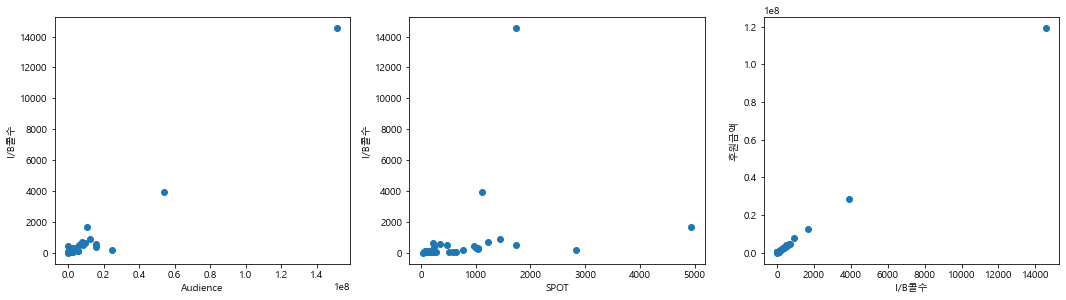

In [6]:
# Impression이 커질수록 I/B 콜이 커지는 경향성을 보임
fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(2,3,1)
x1 = datas_1["Audience"]
y1 = datas_1["I/B콜수"]
plt.scatter(x1, y1)
plt.xlabel('Audience')
plt.ylabel('I/B콜수')

# SPOT의 경우 Impression 대비 I/B의 분포가 커지는 경향
ax2 = fig.add_subplot(2,3,2)
x2 = datas_1["SPOT"]
y1 = datas_1["I/B콜수"]
plt.scatter(x2, y1)
plt.xlabel('SPOT')
plt.ylabel('I/B콜수')

# 콜수가 많아지면 후원금액이 많아진다.
ax3 = fig.add_subplot(2,3,3)
x3 = datas_1["I/B콜수"]
#y2 = datas_1["정기후원"]
y3 = datas_1["후원금액"]
plt.scatter(x3, y3)
plt.xlabel('I/B콜수')
plt.ylabel('후원금액')
plt.show()

In [7]:
df1 = rating[["Date","Net Price", "Audience", "SPOT","Film","Station"]]
df_features = df1.groupby("Film").sum().reset_index()
df2 = donour[["Date","I/B콜수", "응대호", "정기후원","후원금액","Film","Station"]]
df_targets = df2.groupby("Film").sum().reset_index()
datas_2 = pd.merge(df_features, df_targets, how='inner',on='Film')
datas_2.head(1)

,Film,Net Price,Audience,SPOT,I/B콜수,응대호,정기후원,후원금액
0,JUST,1.474807e+08,1.559313e+07,1984,1748,1644,604,12737000


In [8]:
# 날짜별로 특성만 가져오기
df1 = rating[["Date","Net Price", "Audience", "SPOT"]]
df_features = df1.groupby("Date").sum().reset_index()
# 날짜별로 라벨만 가져오기
df2 = donour[["Date","I/B콜수", "응대호", "정기후원", "후원금액"]]
df_targets = df2.groupby("Date").sum().reset_index()
# 분석데이터 가져오기
df_features
datas_3 = pd.merge(df_features, df_targets, how='inner',on='Date')
datas_3 = datas_3.groupby("Date").sum().reset_index()
datas_3.head(1)

,Date,Net Price,Audience,SPOT,I/B콜수,응대호,정기후원,후원금액
0,2018-01-01,225988.700565,82283.0,9,0,0,1,20000


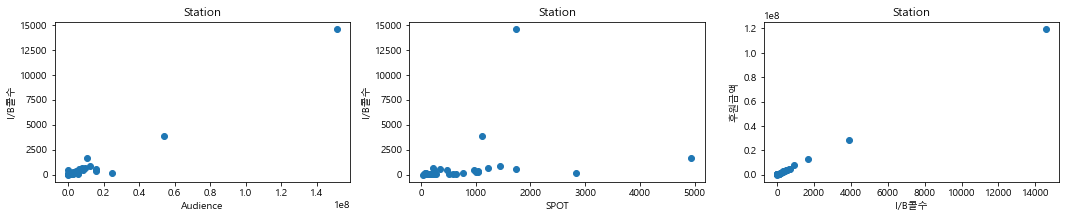

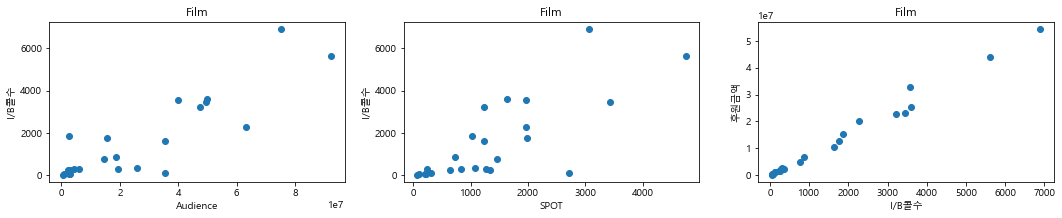

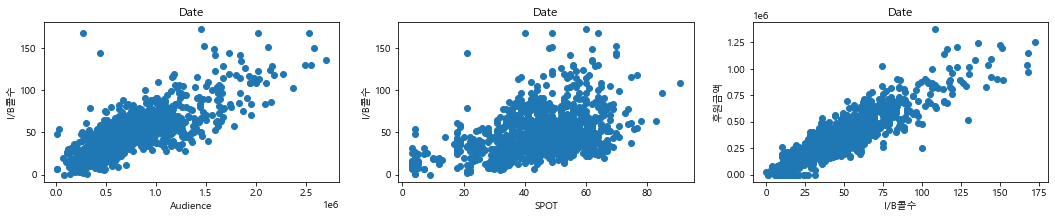

In [9]:
fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(3,3,1)
x1 = datas_1["Audience"]
y1 = datas_1["I/B콜수"]
plt.scatter(x1, y1)
plt.xlabel('Audience')
plt.ylabel('I/B콜수')
plt.title('Station')

ax2 = fig.add_subplot(3,3,2)
x2 = datas_1["SPOT"]
y1 = datas_1["I/B콜수"]
plt.scatter(x2, y1)
plt.xlabel('SPOT')
plt.ylabel('I/B콜수')
plt.title('Station')

ax3 = fig.add_subplot(3,3,3)
x3 = datas_1["I/B콜수"]
#y2 = datas_1["정기후원"]
y3 = datas_1["후원금액"]
plt.scatter(x3, y3)
plt.xlabel('I/B콜수')
plt.ylabel('후원금액')
plt.title('Station')
# ====================================================================================================

fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(3,3,4)
x1 = datas_2["Audience"]
y1 = datas_2["I/B콜수"]
plt.scatter(x1, y1)
plt.xlabel('Audience')
plt.ylabel('I/B콜수')
plt.title('Film')

ax2 = fig.add_subplot(3,3,5)
x2 = datas_2["SPOT"]
y1 = datas_2["I/B콜수"]
plt.scatter(x2, y1)
plt.xlabel('SPOT')
plt.ylabel('I/B콜수')
plt.title('Film')

ax3 = fig.add_subplot(3,3,6)
x3 = datas_2["I/B콜수"]
#y2 = datas_1["정기후원"]
y3 = datas_2["후원금액"]
plt.scatter(x3, y3)
plt.xlabel('I/B콜수')
plt.ylabel('후원금액')
plt.title('Film')


# ====================================================================================================

fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(3,3,7)
x1 = datas_3["Audience"]
y1 = datas_3["I/B콜수"]
plt.scatter(x1, y1)
plt.xlabel('Audience')
plt.ylabel('I/B콜수')
plt.title('Date')

ax2 = fig.add_subplot(3,3,8)
x2 = datas_3["SPOT"]
y1 = datas_3["I/B콜수"]
plt.scatter(x2, y1)
plt.xlabel('SPOT')
plt.ylabel('I/B콜수')
plt.title('Date')

ax3 = fig.add_subplot(3,3,9)
x3 = datas_3["I/B콜수"]
#y2 = datas_1["정기후원"]
y3 = datas_3["후원금액"]
plt.scatter(x3, y3)
plt.xlabel('I/B콜수')
plt.ylabel('후원금액')
plt.title('Date')
plt.show()


### Station, Film, Date 별 Audience, SPOT과 후원금액, 정기후원, 응대호,I/B콜수의 상관관계

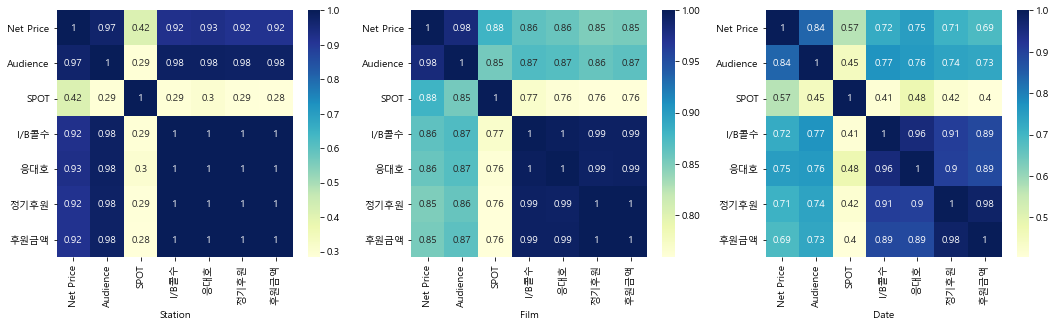

In [10]:
fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(2,3,1)
sns.heatmap(datas_1.corr(), cmap="YlGnBu", annot=True)
plt.xlabel("Station")

ax2 = fig.add_subplot(2,3,2)
sns.heatmap(datas_2.corr(), cmap="YlGnBu", annot=True)
plt.xlabel("Film")

ax3 = fig.add_subplot(2,3,3)
sns.heatmap(datas_3.corr(), cmap="YlGnBu", annot=True)
plt.xlabel("Date")
plt.show()

In [11]:
datas_1.sort_values(by=['후원금액'], axis=0, ascending=False).head(10)

,Station,Net Price,Audience,SPOT,I/B콜수,응대호,정기후원,후원금액
8,EBS,6.851879e+08,1.512981e+08,1732,14560,11795,5437,119372000
24,YTN,3.600000e+08,5.416008e+07,1113,3904,3497,1288,28620000
5,C채널,1.073928e+08,1.071873e+07,4937,1671,1554,603,12490000
4,CTS,1.217952e+08,1.217952e+07,1444,905,866,348,7747000
3,CNTV,7.801370e+07,7.751111e+06,1229,694,672,226,4785000
23,TV조선,5.960856e+07,9.739410e+06,229,628,586,217,4420000
29,채널A,1.000000e+08,1.566664e+07,344,557,506,193,4095000
15,MBC드라마,7.000000e+07,8.235863e+06,485,500,448,185,3905000
17,MBN Plus,7.433333e+07,6.048912e+06,1744,526,451,171,3760000
32,평화방송,4.000000e+07,3.393900e+04,978,422,401,135,2766666


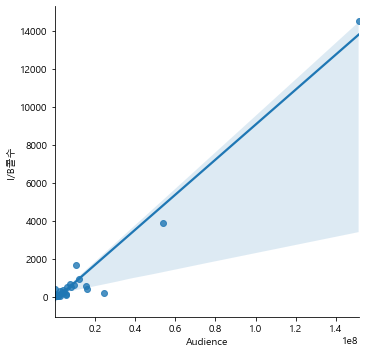

In [12]:
sns.lmplot(x='Audience', y='I/B콜수', data=datas_1)

## Station 컬럼 별 순위

In [13]:
datas_1.head(3)

,Station,Net Price,Audience,SPOT,I/B콜수,응대호,정기후원,후원금액
0,BBS,5.000000e+06,5.000000e+05,188,47,32,10,205000
1,BTN,8.863636e+06,8.863636e+05,214,37,35,15,280000
2,CBS,2.475190e+08,2.460599e+07,2834,200,184,68,1475000


In [14]:
#fig = plt.figure(figsize=(10,2))
#plt.bar(datas_1_spot['Station'],datas_1_spot['후원금액'])
#datas_1_spot

### Station기준 후원금액 정렬

,Station,Net Price,Audience,SPOT,I/B콜수,응대호,정기후원,후원금액
8,EBS,6.851879e+08,1.512981e+08,1732,14560,11795,5437,119372000
24,YTN,3.600000e+08,5.416008e+07,1113,3904,3497,1288,28620000
5,C채널,1.073928e+08,1.071873e+07,4937,1671,1554,603,12490000
4,CTS,1.217952e+08,1.217952e+07,1444,905,866,348,7747000


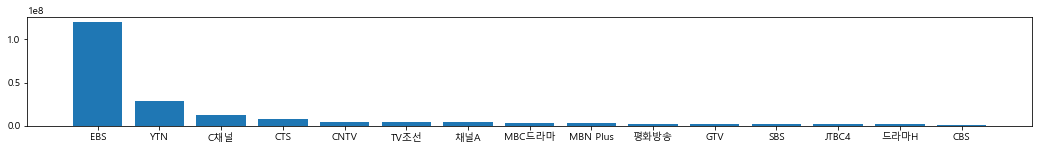

In [15]:
datas_1_후원금액 = datas_1.sort_values(by=['후원금액'], axis=0, ascending=False).head(15)
fig = plt.figure(figsize=(18,2))
plt.bar(datas_1_후원금액['Station'],datas_1_후원금액['후원금액'])
datas_1_후원금액.head(4)

### Station 기준 Net Price정렬

,Station,Net Price,Audience,SPOT,I/B콜수,응대호,정기후원,후원금액
8,EBS,6.851879e+08,1.512981e+08,1732,14560,11795,5437,119372000
24,YTN,3.600000e+08,5.416008e+07,1113,3904,3497,1288,28620000
2,CBS,2.475190e+08,2.460599e+07,2834,200,184,68,1475000
4,CTS,1.217952e+08,1.217952e+07,1444,905,866,348,7747000


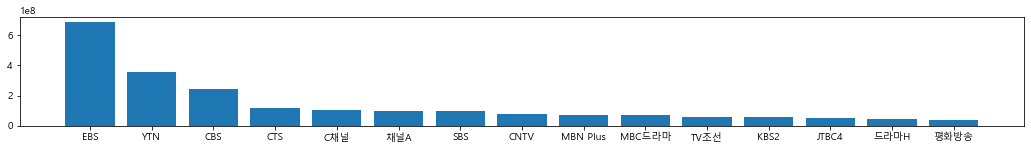

In [16]:
datas_1_NetPrice = datas_1.sort_values(by=['Net Price'], axis=0, ascending=False).head(15)
fig = plt.figure(figsize=(18,2))
plt.bar(datas_1_NetPrice['Station'],datas_1_NetPrice['Net Price'])
datas_1_NetPrice.head(4)

### Station 기준 Audience 정렬

,Station,Net Price,Audience,SPOT,I/B콜수,응대호,정기후원,후원금액
8,EBS,6.851879e+08,1.512981e+08,1732,14560,11795,5437,119372000
24,YTN,3.600000e+08,5.416008e+07,1113,3904,3497,1288,28620000
2,CBS,2.475190e+08,2.460599e+07,2834,200,184,68,1475000
20,SBS,9.968000e+07,1.593219e+07,241,388,355,118,2655000


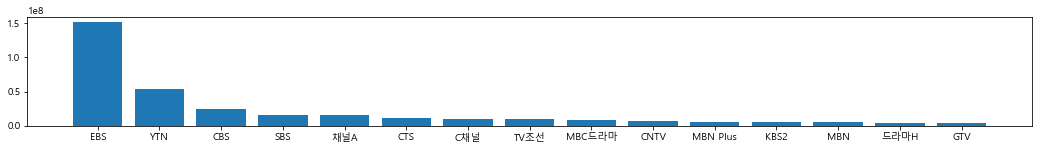

In [17]:
datas_1_Audience = datas_1.sort_values(by=['Audience'], axis=0, ascending=False).head(15)
fig = plt.figure(figsize=(18,2))
plt.bar(datas_1_Audience['Station'],datas_1_Audience['Audience'])
datas_1_Audience.head(4)

### Station 기준 I/B콜수 정렬

,Station,Net Price,Audience,SPOT,I/B콜수,응대호,정기후원,후원금액
8,EBS,6.851879e+08,1.512981e+08,1732,14560,11795,5437,119372000
24,YTN,3.600000e+08,5.416008e+07,1113,3904,3497,1288,28620000
5,C채널,1.073928e+08,1.071873e+07,4937,1671,1554,603,12490000
4,CTS,1.217952e+08,1.217952e+07,1444,905,866,348,7747000


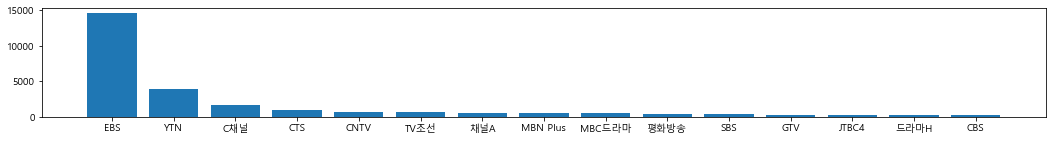

In [18]:
datas_1_IB콜수 = datas_1.sort_values(by=['I/B콜수'], axis=0, ascending=False).head(15)
fig = plt.figure(figsize=(18,2))
plt.bar(datas_1_IB콜수['Station'],datas_1_IB콜수['I/B콜수'])
datas_1_IB콜수.head(4)

### Station 기준 응대호 정렬

,Station,Net Price,Audience,SPOT,I/B콜수,응대호,정기후원,후원금액
8,EBS,6.851879e+08,1.512981e+08,1732,14560,11795,5437,119372000
24,YTN,3.600000e+08,5.416008e+07,1113,3904,3497,1288,28620000
5,C채널,1.073928e+08,1.071873e+07,4937,1671,1554,603,12490000
4,CTS,1.217952e+08,1.217952e+07,1444,905,866,348,7747000


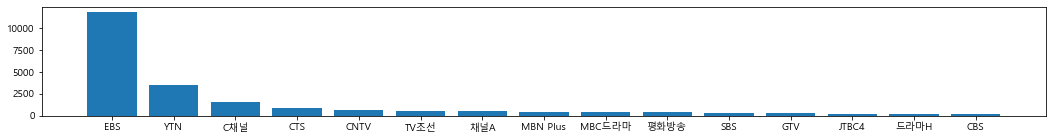

In [19]:
datas_1_응대호 = datas_1.sort_values(by=['응대호'], axis=0, ascending=False).head(15)
fig = plt.figure(figsize=(18,2))
plt.bar(datas_1_응대호['Station'],datas_1_응대호['응대호'])
datas_1_응대호.head(4)

### Station 기준 SPOT 정렬

,Station,Net Price,Audience,SPOT,I/B콜수,응대호,정기후원,후원금액
5,C채널,1.073928e+08,1.071873e+07,4937,1671,1554,603,12490000
2,CBS,2.475190e+08,2.460599e+07,2834,200,184,68,1475000
17,MBN Plus,7.433333e+07,6.048912e+06,1744,526,451,171,3760000
8,EBS,6.851879e+08,1.512981e+08,1732,14560,11795,5437,119372000


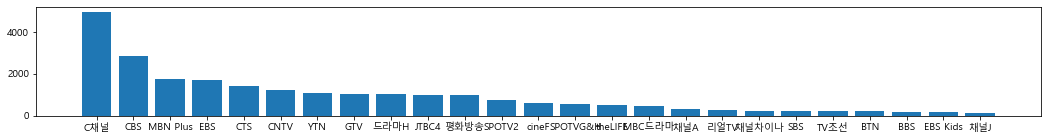

In [20]:
datas_1_SPOT = datas_1.sort_values(by=['SPOT'], axis=0, ascending=False).head(25)
fig = plt.figure(figsize=(18,2))
plt.bar(datas_1_SPOT['Station'],datas_1_SPOT['SPOT'])
datas_1_SPOT.head(4)

### Station 기준 정기후원 정렬

,Station,Net Price,Audience,SPOT,I/B콜수,응대호,정기후원,후원금액
8,EBS,6.851879e+08,1.512981e+08,1732,14560,11795,5437,119372000
24,YTN,3.600000e+08,5.416008e+07,1113,3904,3497,1288,28620000
5,C채널,1.073928e+08,1.071873e+07,4937,1671,1554,603,12490000
4,CTS,1.217952e+08,1.217952e+07,1444,905,866,348,7747000


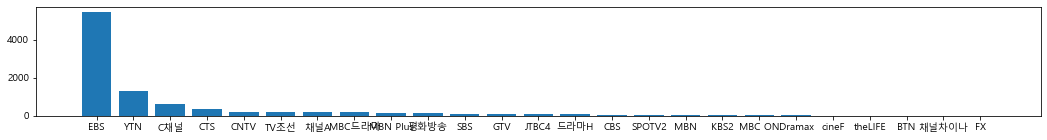

In [21]:
datas_1_정기후원 = datas_1.sort_values(by=['정기후원'], axis=0, ascending=False).head(25)
fig = plt.figure(figsize=(18,2))
plt.bar(datas_1_정기후원['Station'],datas_1_정기후원['정기후원'])
datas_1_정기후원.head(4)

###  특징 비중 일순위는 정기후원, 마지막 순위는 SPOT에 두어야 합니다.
 - 상관관계에서 SPOT는 다른 특성들과 다르게 낮은 결과를 보이고 있습니다.
 - 효율 특성 선택에 있어서 SPOT에 높은 비중을 두면 비효율적이라는 것을 알 수 있습니다.
 - 정기후원이 상관관계에서 1순위를 차지합니다.
 - 높은 정기후원을 받기 위해서는, I/B콜수, 응대호가 높은 비중을 차지합니다.

<AxesSubplot:>

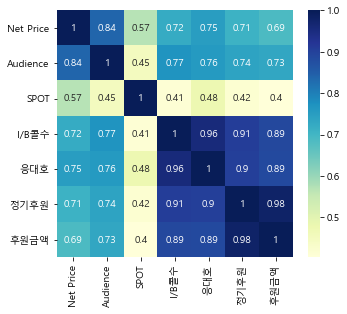

In [22]:
fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(2,3,1)
sns.heatmap(datas_3.corr(), cmap="YlGnBu", annot=True)

In [23]:
# Film

In [24]:
df1 = rating[["Date","Net Price", "Audience", "SPOT","Film","Station"]]
df_features = df1.groupby("Film").sum().reset_index()
df2 = donour[["Date","I/B콜수", "응대호", "정기후원","후원금액","Film","Station"]]
df_targets = df2.groupby("Film").sum().reset_index()
datas_2 = pd.merge(df_features, df_targets, how='inner',on='Film')
datas_2

,Film,Net Price,Audience,SPOT,I/B콜수,응대호,정기후원,후원금액
0,JUST,1.474807e+08,1.559313e+07,1984,1748,1644,604,12737000
1,JUST신구,1.638540e+08,3.986399e+07,1969,3569,3185,1511,32700000
2,난방비,1.397664e+08,2.605709e+07,1071,347,334,109,2245000
3,난방비2,2.412139e+08,4.985213e+07,1633,3589,3248,1113,25260000
4,동아프리카,4.183119e+07,4.207179e+06,833,303,287,110,2320000
5,브라더스,1.396977e+07,2.798817e+06,215,74,72,22,410000
6,소희편,2.955963e+08,4.744754e+07,1229,3221,2749,1045,22575000
7,수연,2.463402e+08,3.559602e+07,2718,129,123,56,1215000
8,시설,4.757512e+08,7.510028e+07,3068,6890,5775,2481,54363000
9,시설보호지온,5.325007e+08,9.236450e+07,4752,5618,5040,1983,43953000


,Film,Net Price,Audience,SPOT,I/B콜수,응대호,정기후원,후원금액
8,시설,4.757512e+08,7.510028e+07,3068,6890,5775,2481,54363000
9,시설보호지온,5.325007e+08,9.236450e+07,4752,5618,5040,1983,43953000
1,JUST신구,1.638540e+08,3.986399e+07,1969,3569,3185,1511,32700000
3,난방비2,2.412139e+08,4.985213e+07,1633,3589,3248,1113,25260000


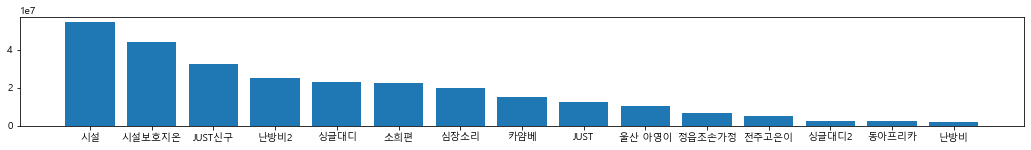

In [25]:
datas_2_후원금액 = datas_2.sort_values(by=['후원금액'], axis=0, ascending=False).head(15)
fig = plt.figure(figsize=(18,2))
plt.bar(datas_2_후원금액['Film'],datas_2_후원금액['후원금액'])
datas_2_후원금액.head(4)

,Film,Net Price,Audience,SPOT,I/B콜수,응대호,정기후원,후원금액
8,시설,4.757512e+08,7.510028e+07,3068,6890,5775,2481,54363000
9,시설보호지온,5.325007e+08,9.236450e+07,4752,5618,5040,1983,43953000
1,JUST신구,1.638540e+08,3.986399e+07,1969,3569,3185,1511,32700000
3,난방비2,2.412139e+08,4.985213e+07,1633,3589,3248,1113,25260000


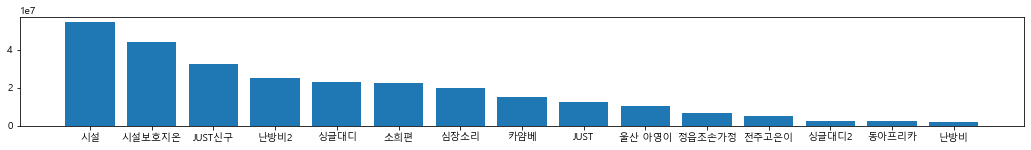

In [26]:
datas_2_후원금액 = datas_2.sort_values(by=['후원금액'], axis=0, ascending=False).head(15)
fig = plt.figure(figsize=(18,2))
plt.bar(datas_2_후원금액['Film'],datas_2_후원금액['후원금액'])
datas_2_후원금액.head(4)

,Film,Net Price,Audience,SPOT,I/B콜수,응대호,정기후원,후원금액
9,시설보호지온,5.325007e+08,9.236450e+07,4752,5618,5040,1983,43953000
12,싱글대디,2.833648e+08,4.939722e+07,3426,3450,2511,1063,23075000
8,시설,4.757512e+08,7.510028e+07,3068,6890,5775,2481,54363000
7,수연,2.463402e+08,3.559602e+07,2718,129,123,56,1215000


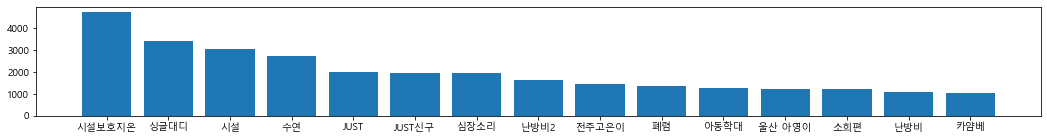

In [27]:
datas_2_SPOT = datas_2.sort_values(by=['SPOT'], axis=0, ascending=False).head(15)
fig = plt.figure(figsize=(18,2))
plt.bar(datas_2_SPOT['Film'],datas_2_SPOT['SPOT'])
datas_2_SPOT.head(4)

### Station과 동일한 상관관계를 가지고 있습니다.
 - 특징 비중 일순위는 정기후원, 마지막 순위는 SPOT에 두어야 합니다.

<AxesSubplot:>

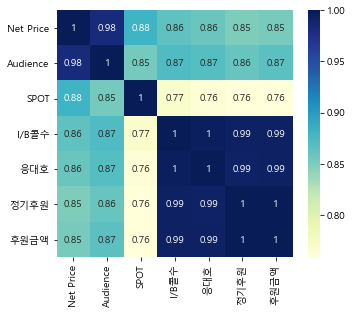

In [28]:
fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(2,3,1)
sns.heatmap(datas_2.corr(), cmap="YlGnBu", annot=True)

In [29]:
df1 = rating[["Date","Net Price", "Audience", "SPOT","Film","Station","Daypart"]]
df_features = df1.groupby("Daypart").sum().reset_index()
df2 = donour[["Date","I/B콜수", "응대호", "정기후원","후원금액","Film","Station", "Daypart"]]
df_targets = df2.groupby("Daypart").sum().reset_index()
datas_4 = pd.merge(df_features, df_targets, how='inner',on='Daypart')
datas_4

,Daypart,Net Price,Audience,SPOT,I/B콜수,응대호,정기후원,후원금액
0,01시대,1.264736e+07,2.330446e+06,240,92,18,0,0
1,02시대,1.413134e+07,2.130401e+06,257,68,12,0,0
2,03시대,1.129107e+07,1.335629e+06,298,34,7,0,0
3,04시대,9.222455e+06,4.608598e+05,294,19,2,0,0
4,05시대,1.547018e+07,1.054790e+06,530,38,2,0,0
5,06시대,2.237017e+07,2.911762e+06,607,138,7,0,0
6,07시대,2.102798e+07,2.411073e+06,600,159,24,0,0
7,08시대,8.008384e+07,1.046166e+07,1194,625,499,76,1545000
8,09시대,2.619837e+08,4.249924e+07,3414,2831,2596,1005,21962000
9,10시대,2.252534e+08,2.722674e+07,3024,2359,2228,874,18935000


In [30]:
datas_4.sort_values(by=['후원금액'], axis=0, ascending=False)

,Daypart,Net Price,Audience,SPOT,I/B콜수,응대호,정기후원,후원금액
20,21시대,6.306132e+08,1.464964e+08,2129,6961,5883,2387,52292500
18,19시대,4.995456e+08,9.482670e+07,4065,6928,5780,2209,48070000
19,20시대,3.192143e+08,4.853041e+07,2690,4077,3481,1648,36312500
11,12시대,4.908247e+08,8.231180e+07,4762,4825,4280,1613,35125000
17,18시대,3.802479e+08,6.124194e+07,4619,4157,3708,1443,31118000
12,13시대,3.239719e+08,5.354868e+07,3597,3305,3011,1227,26658000
13,14시대,2.809970e+08,4.796003e+07,3273,3118,2904,1002,22827000
16,17시대,2.716881e+08,3.989523e+07,2816,2855,2581,1018,22180000
8,09시대,2.619837e+08,4.249924e+07,3414,2831,2596,1005,21962000
10,11시대,3.451744e+08,4.443015e+07,3750,3368,3004,1006,21939666


In [31]:
datas_4.sort_values(by=['정기후원'], axis=0, ascending=False)

,Daypart,Net Price,Audience,SPOT,I/B콜수,응대호,정기후원,후원금액
20,21시대,6.306132e+08,1.464964e+08,2129,6961,5883,2387,52292500
18,19시대,4.995456e+08,9.482670e+07,4065,6928,5780,2209,48070000
19,20시대,3.192143e+08,4.853041e+07,2690,4077,3481,1648,36312500
11,12시대,4.908247e+08,8.231180e+07,4762,4825,4280,1613,35125000
17,18시대,3.802479e+08,6.124194e+07,4619,4157,3708,1443,31118000
12,13시대,3.239719e+08,5.354868e+07,3597,3305,3011,1227,26658000
16,17시대,2.716881e+08,3.989523e+07,2816,2855,2581,1018,22180000
10,11시대,3.451744e+08,4.443015e+07,3750,3368,3004,1006,21939666
8,09시대,2.619837e+08,4.249924e+07,3414,2831,2596,1005,21962000
13,14시대,2.809970e+08,4.796003e+07,3273,3118,2904,1002,22827000


In [34]:
df1 = rating[["Net Price", "Audience", "SPOT", "Time"]]
#df_features = df1.groupby("Time").sum().reset_index()
df2 = donour[["I/B콜수", "응대호", "정기후원","후원금액", "Time"]]
#df_targets = df2.groupby("Time").sum().reset_index()
datas_4 = pd.merge(df1, df2, how='inner',on='Time')
datas_4

,Net Price,Audience,SPOT,Time,I/B콜수,응대호,정기후원,후원금액
0,41512.915129,4151.291513,1,10:15:00,1,1,0,0
1,41512.915129,4151.291513,1,10:15:00,1,1,0,0
2,41512.915129,4151.291513,1,10:15:00,1,1,0,0
3,41512.915129,4151.291513,1,10:15:00,1,1,0,0
4,41512.915129,4151.291513,1,10:15:00,0,0,1,20000
...,...,...,...,...,...,...,...,...
668010,0.000000,0.000000,1,23:15:00,1,0,0,0
668011,0.000000,0.000000,1,23:15:00,1,0,0,0
668012,0.000000,0.000000,1,23:15:00,1,0,0,0
668013,0.000000,0.000000,1,23:15:00,1,0,0,0


In [36]:
datas_4.sort_values(by=['후원금액'], axis=0, ascending=False).head()

,Net Price,Audience,SPOT,Time,I/B콜수,응대호,정기후원,후원금액
626574,30138.637734,0.000000,1,20:00:00,0,0,1,500000
622986,29256.875366,2925.687537,1,20:00:00,0,0,1,500000
614614,29256.875366,2925.687537,1,20:00:00,0,0,1,500000
618202,29256.875366,2925.687537,1,20:00:00,0,0,1,500000
629564,60240.963855,6024.096386,1,20:00:00,0,0,1,500000
